# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


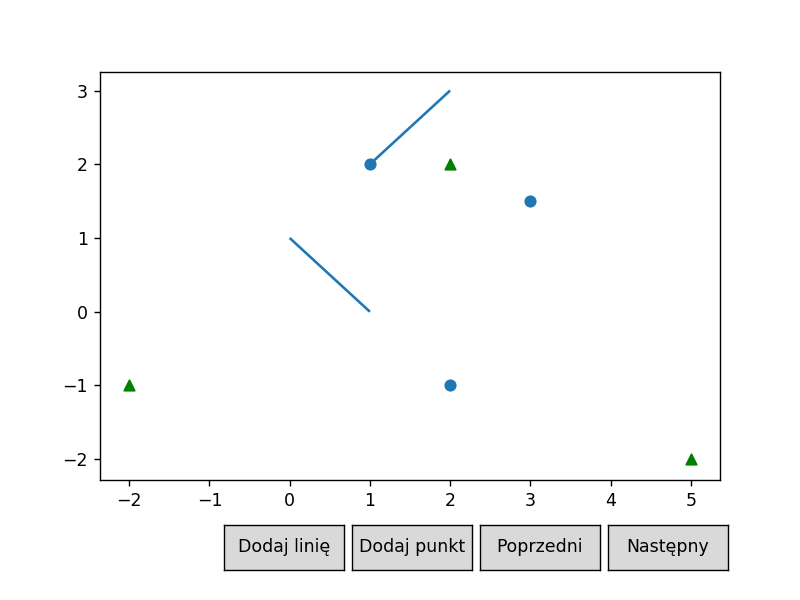

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(3,2),(2,3)]])]))

plot.draw() 


In [4]:
###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

SyntaxError: invalid syntax (<ipython-input-4-b10a3b8ed870>, line 3)

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [5]:
from queue import PriorityQueue

def punktPrzeciecia():
    print("do napisania")
    
def insert(Q, list):
    for i in range(100):
            Q.put((list[i][0], i, -1))
            Q.put((list[i][1], -1, i))


### Rozwiązanie

<IPython.core.display.Javascript object>


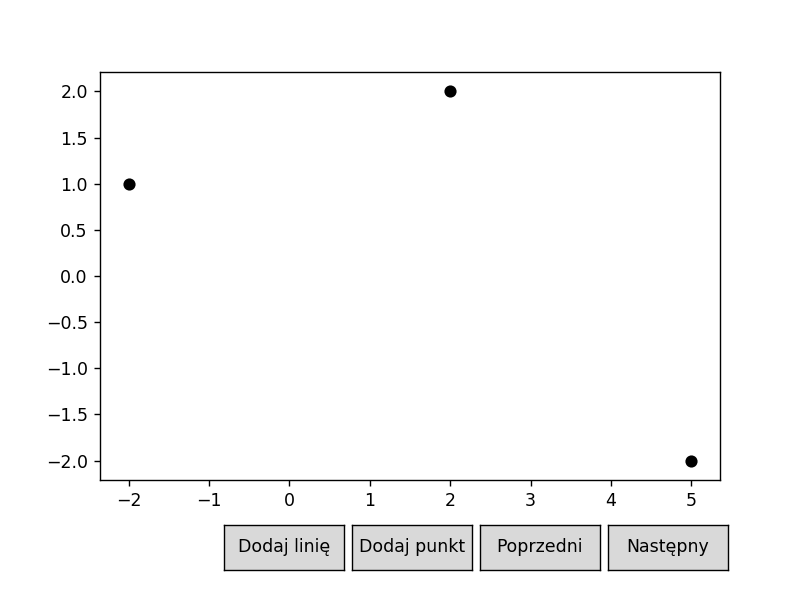

In [6]:
%matplotlib notebook
from queue import PriorityQueue
import random
odcinki = []
for i in range(100):
    a = random.uniform(0, 90)
    b = random.uniform(0, 100)
    c = random.uniform(a, 100)
    d = random.uniform(0, 100)
    odcinki.append([(a,b),(c,d)])
    
scenes=[Scene([PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')]),
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])]]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(3,2),(2,3)]])]))

plot.draw() 

In [7]:
class Node:
    def __init__(self, no):
        self.key = no
        self.left = None
        self.right = None
        self.parent = None

        
class Tree:
    def __init__(self, lines):
        self.lines = lines
        self.root = None
        self.x  = 0
        self.table = [None] * len(lines)
        
        
    def succ(self, line_no):
        node = self.table[line_no]
        if node is None:
            return None
        
        if node.right is not None:
            node = node.right
            while node.left is not None:
                node = node.left
        else:        
            while True:
                if node.parent is None:
                    node = None
                    break
                if node.parent.left == node:
                    node = node.parent
                    break
                else:
                    node = node.parent

        if node is None:
            return None
        else:
            return node.key
        
        
    def prev(self, line_no):
        node = self.table[line_no]
        if node is None:
            return None
        if node.left is not None:
            node = node.left
            while node.right is not None:
                node = node.right
        else:
            while True:
                if node.parent is None:
                    node = None
                    break
                if node.parent.right == node:
                    node = node.parent
                    break
                else:
                    node = node.parent

        if node is None:
            return None
        else:
            return node.key
    
    
    def add(self, line_no):
        new_node = Node(line_no)
        self.table[line_no] = new_node
               
        if self.root is None:
            self.root = new_node #if no root then create root
            return True
        node = self.root
        while True:
            if getY(self.lines[node.key], self.x) > getY(self.lines[line_no], self.x): #line is below line in tree
                if node.left is None:
                    node.left = new_node     
                    new_node.parent = node
                    return True
                else: 
                    node = node.left 
            else:                                                                       #line is above line in tree
                if node.right is None:
                    node.right = new_node
                    new_node.parent = node
                    return True
                else: 
                    node = node.right 

                    
    def remove(self, line_no):
        node = self.table[line_no]
        if node is None:
            return False
        
        if node.left is None and node.right is None:           #node has no children
            if node == self.root:                                 #node is root
                self.root = None
            else:                                                 #node is not root
                if node.parent.left == node:                         #node is left child
                    node.parent.left = None
                else:                                                #node is right child
                    node.parent.right = None
        
        elif node.left is None:                                #node has right chlid only
            if node == self.root:                                 #node is root
                self.root = node.right
                node.right.parent = None
            else:                                                 #node is not root
                if node.parent.left == node:                         #node is left child
                    node.parent.left = node.right
                    node.right.parent = node.parent
                else:                                                #node is right child
                    node.parent.right = node.right 
                    node.right.parent = node.parent              
        
        elif node.right is None:                                #node has left chlid only
            if node == self.root:                                 #node is root
                self.root = node.left
                node.left.parent = None
            else:                                                 #node is not root
                if node.parent.left == node:                         #node is left child
                    node.parent.left = node.left
                    node.left.parent = node.parent
                else:                                                #node is right child
                    node.parent.right = node.left 
                    node.left.parent = node.parent
        
        else:                                                   #node has right and left children
            succ = self.table[self.succ(line_no)]                   #finding successor of node
            if node.right != succ:                      
                if succ.right is None:                   #dealing with succ's right
                    succ.parent.left = None
                else:
                    succ.parent.left = succ.right
                    succ.right.parent = succ.parent         
                succ.right = node.right                  #dealing with node's right
                node.right.parent = succ
            
            succ.left = node.left                       # dealing with succ's 
            node.left.parent = succ                     # and node's lefts
            
            if node == self.root:                       # dealing with node's and succ's parent
                self.root = succ
                succ.parent = None
            else:                                                 
                if node.parent.left == node:                         
                    node.parent.left = succ
                    succ.parent = node.parent
                else:                                                
                    node.parent.right = succ
                    succ.parent = node.parent
        
        
        self.table[line_no] = None
        del node
        return True

    def active_lines(self):
        actlines = []
        self.active_lines2(self.root, actlines)
        return actlines
    
    def active_lines2(self, node, actlines):
        if node is not None:
            actlines.append(self.lines[node.key])
            self.active_lines2(node.left, actlines)
            self.active_lines2(node.right, actlines)
    
    def Visual(self):
        self.Visual2(self.root, 0, 0)
  

    def Visual2(self, node, n, direct):
        if node is not None:
            for i in range(n):
                print("\t", end = '')
            if(direct == -1):
                print ("L:", end = '')
            if(direct == 1):
                print ("R:", end = '')
            print (node.key)
            self.Visual2(node.left, n+1, -1)
            self.Visual2(node.right, n+1, 1)
 

    def swap(self, line1_no, line2_no):
        node1 = self.table[line1_no]
        node2 = self.table[line2_no]
        if node1 is None or node2 is None:
            raise ValueError('one of the lines is not in tree')
        tmp = node1.key
        node1.key = node2.key
        node2.key = tmp
        
        self.table[line1_no] = node2
        self.table[line2_no] = node1
    
    def update(self, x):
        self.x = x

In [13]:
import random

def generowanieOdcinkow(number):
    odcinki = []
    random.seed()
    for i in range(number):
        while True:
            p1 = (random.uniform(0, 100), random.uniform(0, 100)) #creating 2 
            p2 = (random.uniform(0, 100), random.uniform(0, 100)) #ends of line
            if p1[0] != p2[0]: # if line is vertical create new one
                break
        
        if p1[0] < p2[0]:
            odcinki.append([p1, p2]) 
        else:
            odcinki.append([p2, p1]) 
    return odcinki

In [14]:
def punktPrzeciecia(lines, indeks1, indeks2):
    if indeks1 is None or indeks2 is None:
        return None
    
    A = lines[indeks1][0]
    B = lines[indeks1][1]
    C = lines[indeks2][0]
    D = lines[indeks2][1]
    
    W = (B[0] - A[0])*(C[1] - D[1]) - (C[0] - D[0])*(B[1] - A[1])
    if W == 0:
        return None
    Wk = (C[0] - A[0])*(C[1] - D[1]) - (C[0] - D[0])*(C[1] - A[1])
    Wt = (B[0] - A[0])*(C[1] - A[1]) - (C[0] - A[0])*(B[1] - A[1])
    k = Wk/W
    t = Wt/W
    if k > 1 or k < 0 or t < 0 or t > 1:
        return None
    else:
        p = ((1-k)*A[0] + k*B[0], (1-k)*A[1] + k*B[1])
        return ((p, indeks1, indeks2))


def getY(line, x):
    p1 = line[0]
    p2 = line[1]
    k = (x - p1[0])/(p2[0] - p1[0])
    y = p1[1] + k*(p2[1] - p1[1])
    return y

In [15]:
from queue import PriorityQueue

class Kolejka:
    def __init__(self):
        self.Q = PriorityQueue()
        self.s = set()
        
    def put(self, item):
        if item[1] == -1 or item[2] == -1: 
            self.Q.put(item)
        else: 
            item2 = (item[1], item[2])
            item3 = (item[2], item[1])
            if item2 not in self.s and item3 not in self.s:
                self.s.add(item2)
                self.Q.put(item)
            
    def get(self):
        return self.Q.get()
            
    def empty(self):
        return self.Q.empty()

In [16]:

def zamiatanie(lines):
    Events = Kolejka()
    T = Tree(lines) 
    pktyPrzeciecia = [] 
    points = [] 
    for i in range(len(lines)):
        if lines[i][0][0] < lines[i][1][0]:
            points.append((lines[i][0], i, -1))
            points.append((lines[i][1], -1, i))
        else:
            points.append((lines[i][0], -1, i))
            points.append((lines[i][1], i, -1))   
    for i in range(len(points)):
        Events.put(points[i])
    while not Events.empty():
        s = Events.get() 
        T.update(s[0][0]) 
        if s[2] == -1: 
            T.add(s[1])
            przeciecie = punktPrzeciecia(lines, s[1], T.succ(s[1]))              
            if przeciecie is not None:
                Events.put(przeciecie)     
            przeciecie = punktPrzeciecia(lines, s[1], T.prev(s[1]))
            if przeciecie is not None:
                Events.put(przeciecie)
        elif s[1] == -1:                                    
            przeciecie = punktPrzeciecia(lines, T.succ(s[2]), T.prev(s[2]))                                  
            if przeciecie is not None:
                Events.put(przeciecie)
            T.remove(s[2])
        else: 
            pktyPrzeciecia.append(s)
            T.swap(s[1], s[2])
            przeciecie = punktPrzeciecia(lines, s[1], T.succ(s[1]))
            if przeciecie is not None:        
                Events.put(przeciecie)
            przeciecie = punktPrzeciecia(lines, s[1], T.prev(s[1])) 
            if przeciecie is not None:
                Events.put(przeciecie)
            przeciecie = punktPrzeciecia(lines, s[2], T.succ(s[2]))
            if przeciecie is not None:
                Events.put(przeciecie)
            przeciecie = punktPrzeciecia(lines, s[2], T.prev(s[2])) 
            if przeciecie is not None:
                Events.put(przeciecie)
    return pktyPrzeciecia

In [12]:
lines = generowanieOdcinkow(10)
wynik = zamiatanie(lines)
for przeciecie in wynik:
    print(przeciecie)

((37.723479614450966, 35.698554232085506), 9, 0)
((37.7762292021482, 31.9092008154009), 9, 8)
((37.97088070853907, 17.926089610084), 9, 6)
((39.32706946222484, 18.785851391341588), 4, 6)
((40.1963048257619, 32.82940427850385), 3, 8)
((41.31397354649651, 36.210804391842366), 3, 0)
((41.806495479110815, 37.70088252310567), 3, 7)
((42.39633683973766, 36.36522347188294), 7, 0)
((43.41698561799376, 34.05402783557084), 7, 8)
((53.75844236155238, 37.98623731534826), 8, 0)
((67.8588018449163, 39.99791357345784), 1, 0)
((69.86617351201228, 38.14624973154198), 1, 6)
((74.2181247873224, 40.90518824230465), 0, 6)
